## Project Description ##
This project will train a few supervised learning models to predict a patient's risk for heart disease based on 12 features captured during a visit to a medical facility. The overall goal of this project is to perform data cleaning and analysis and ultimately to compare the efficacy and accuracy of two different model types (Logistic Regression, and Random Forest) and to be able to predict a future patient's risk of heart disease when given feature data.

## Data Source ##
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved February, 2026 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

The Kaggle *Heart Failure Prediction Dataset* was used for this project, which combines different datasets from 5 locations around the world (e.g., United States, Hungary, Switzerland).

Here is a description of the column types...


In [37]:
# Code to read data and display column types
import os
import numpy as np
import pandas as pd

df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.dtypes.to_frame('Data Type')

,Data Type
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


The dataset has 11 features that can be used for analysis to classify a patient as either having heart disease (1) or not (0). The file is formatted as CSV and is 36KB. There are 918 observations before cleaning with 6 numerical features and 5 categorical features.

Here is a preview of some sample data...

In [38]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Exploratory Data Analysis (EDA) ##

The goal of this section is to prepare the data for analysis. We will look for illegal values, values that represent missing data, redundant values and values that should be excluded for one reason or another.

First, let's check to see if there are any NaN values.

In [39]:
nan_columns = df.isna().sum()
print(nan_columns)


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Fortunately, there are no completely invalid observations.

I did not recognize all of the terms used in the dataset, so I used AI to clarify some definitions and reasonable values to assist with strategies for cleaning the data before training. See the section **AI Usage** for more detail. Based on that learning, I determined the only necessary cleaning was to remove 0 values for **Cholesterol** and **RestingBP** since those values indicate an absence of reliable data.

In [49]:
# Utility functions...
def print_stats(df):
    print("\nRestingBP Stats:")
    print(df['RestingBP'].agg(['min', 'max', 'median']))
    print("\nCholesterol Stats:")
    print(df['Cholesterol'].agg(['min', 'max', 'median']))

def clean_df(df):
    print("Dataset shape before cleaning:", df.shape)
    print_stats(df)
    df_cleaned = df[(df['RestingBP'] > 0) & (df['Cholesterol'] > 0)]
    print("\nDataset shape after cleaning:", df_cleaned.shape)
    print_stats(df_cleaned)
    return df_cleaned

df_cleaned = clean_df(df)


Dataset shape before cleaning: (918, 12)

RestingBP Stats:
min         0.0
max       200.0
median    130.0
Name: RestingBP, dtype: float64

Cholesterol Stats:
min         0.0
max       603.0
median    223.0
Name: Cholesterol, dtype: float64

Dataset shape after cleaning: (746, 12)

RestingBP Stats:
min        92.0
max       200.0
median    130.0
Name: RestingBP, dtype: float64

Cholesterol Stats:
min        85.0
max       603.0
median    237.0
Name: Cholesterol, dtype: float64


### Correlation Matrix

Let's produce a correlation matrix to look for collinear features that might be redundant and for features that have no influence on the target heart disease status.

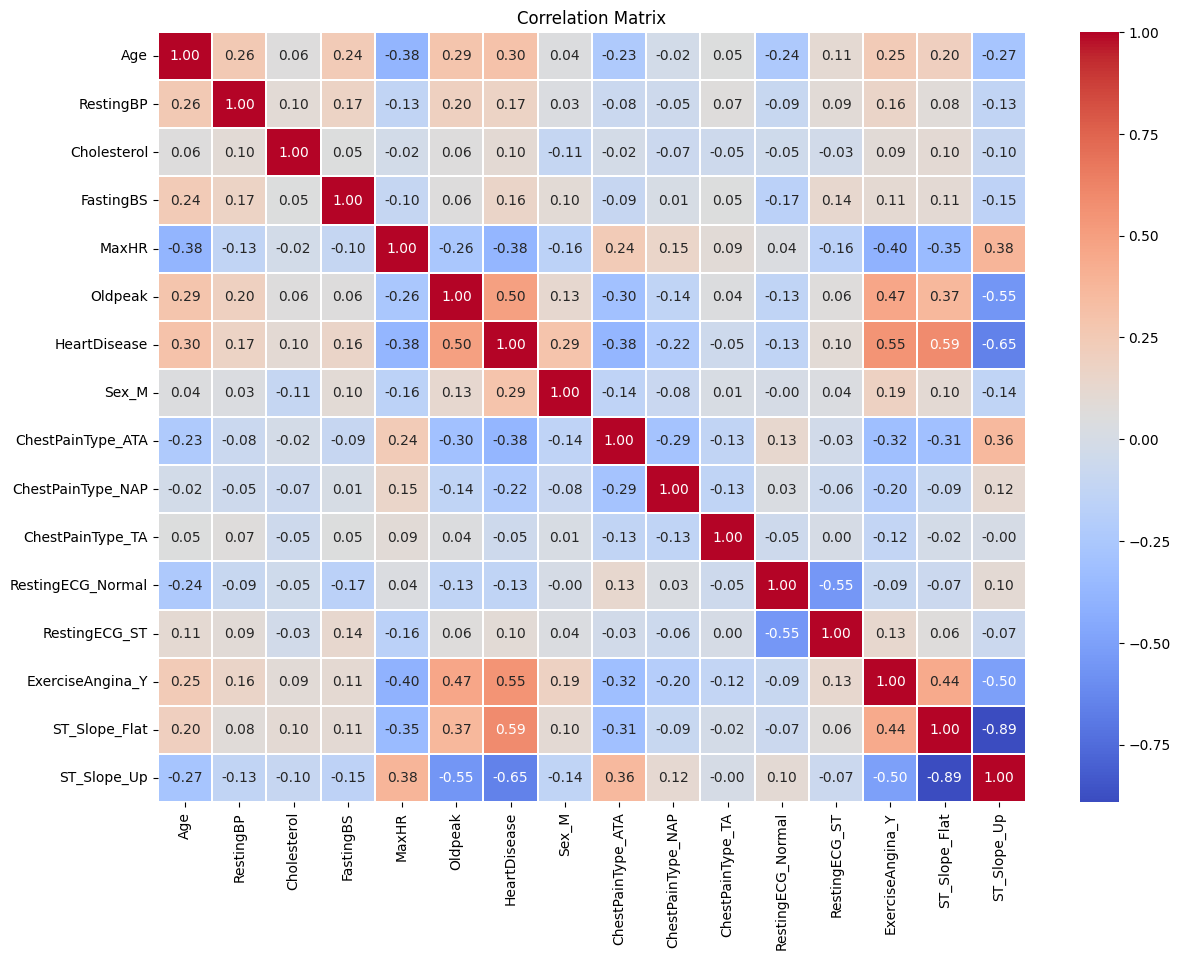

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert textual classifier columns into numerical values for the heat map
df_cm = pd.get_dummies(df_cleaned, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

plt.figure(figsize=(14, 10))
sns.heatmap(df_cm.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

### More Data Cleaning ###
Upon further inspection of the correlation matrix, and looking at the HeartDisease row for any features that have very low correlation, I see that ChestPainType_TA has a value of -0.05. Since this indicates a negative, but low correlation, I will also remove that column from the dataset before training.

Most features do not have a high positive or negative correlation, so I do not need to remove a column that would be redundant during training. 

However, there is a high collinearity (-0.89) between ST_Slope_up and ST_Slope_Flat. I am going to keep both features to see if different model types can utilize both, but it does have the possibility of causing unstable coefficients with logistical regression.

Cholesterol and RestingBP have weak correlations with the target, but I will keep these features in case they uncover interesting relationships with multiple features with an ensemble model.


In [42]:
df_cleaned = df_cleaned.drop('ChestPainType', axis=1)
print('Dropped column "ChestPainType".')

Dropped column "ChestPainType".


Now, let's check the categorical data to ensure there isn't extreme bias in any categorical feature data. Also, make sure the target column, **HeartDisease** is not too unbalanced.

In [43]:
# Check for any categorical data that should be omitted 
for col in df_cleaned.select_dtypes(include=['object', 'bool']).columns:
    print(df_cleaned[col].value_counts(normalize=True).to_string())
    print("\n")

TARGET_COL = 'HeartDisease'
print(df_cleaned[TARGET_COL].value_counts(normalize=True).to_string())
print("\n")

Sex
M    0.756032
F    0.243968


RestingECG
Normal    0.596515
LVH       0.235925
ST        0.167560


ExerciseAngina
N    0.615282
Y    0.384718


ST_Slope
Flat    0.474531
Up      0.467828
Down    0.057641


HeartDisease
0    0.522788
1    0.477212




The distributions of the feature columns and the HeartDisease column are acceptable, so I will not remove any of those columns nor worry about rebalancing the target column. When I split the data for training later, I will make sure to pass the stratify option to keep the same target balance in training and test data.

One final check is to look for any numerical data that is skewed or dominant (e.g., mostly zeros or mostly ones).

In [44]:
def find_dominant_features(df, threshold=0.95):
    bias_found = False
    for col in df.columns:
        # Get the percentage of the most frequent value
        top_value = df[col].value_counts(normalize=True).iloc[0]
        if top_value > threshold:
            print(f"ALERT: '{col}' is {top_value:.2%} the same value.")
            bias_found = True
            
    if not bias_found:
        print("No feature data exceeds 95% dominance.")

find_dominant_features(df_cleaned)

No columns exceed 95% dominance.


### Data Splitting
Now that the data is cleaned, let's split it into 80% training and 20% testing datasets.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report, RocCurveDisplay

df_encoded = pd.get_dummies(df_cleaned, columns=['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)
df_regression = df_encoded.astype({col: 'int' for col in df_encoded.select_dtypes('bool').columns})
X = df_regression.drop(columns=[TARGET_COL])
X_scaled = StandardScaler().fit_transform(X)
y = df_regression[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print('Train data:', len(y_train), 'observations')
print('Test data:', len(y_test), 'observations')


Train data: 596 observations
Test data: 150 observations


## Model Selection

To decide on the models I will explore, I will choose a linear baseline model, LogisticRegression, since it is efficient and will tell me if there is a direct relationship between a particular risk factor (like Cholesterol) and the outcome.

In addition, I will also try a non-linear ensemble model, RandomForest, to see if there are non-linear interactions (e.g., high blood pressure is only dangerous if combined with older patients) that a logistic regression might miss.

I will address the risk of data-inbalance by specifying **class_weight='balanced'** when initializing the LogisticRegression model.

To minimize overfitting, I will set the **max_depth=6** in the RandomForest model.

In [46]:
regression_model = LogisticRegression(solver='liblinear', class_weight='balanced')
regression_model.fit(X_train, y_train)

forest_model = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42)
forest_model.fit(X_train, y_train)

pass

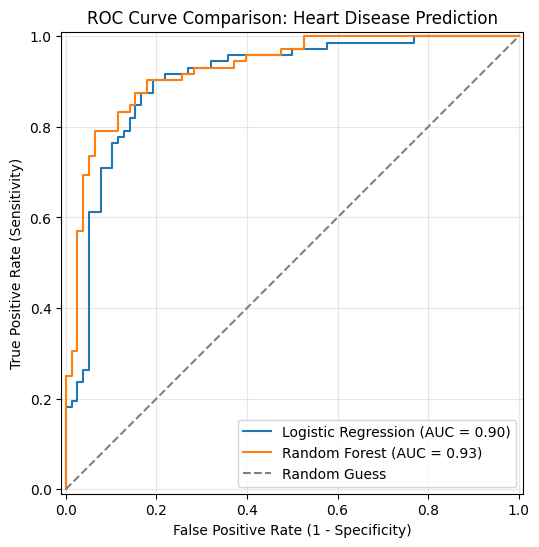

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(regression_model, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(forest_model, X_test, y_test, ax=ax, name='Random Forest')

ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
ax.set_title('ROC Curve Comparison: Heart Disease Prediction')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.legend()
ax.grid(alpha=0.3)

plt.show()

## Results and Analysis

The random forest model slightly outperforms the logistic regression. The AUC value for the random forest is slightly higher, and you can see its curve hugs the top-left corner of the graph a little more than the other one.

### Feature Importance
Now, I will plot the feature importance of the forest model to see if anything else can be learned.

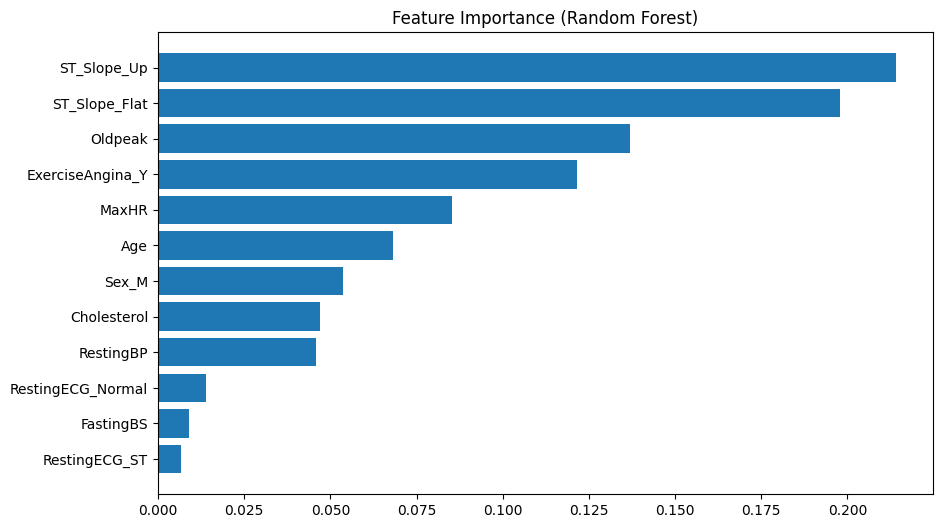

In [48]:
# Extract importance
importances = forest_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance (Random Forest)')
plt.show()

The Random Forest model identifies ST_Slope (Up/Flat), Oldpeak, and ExerciseAngina as the most critical predictors of heart disease in this dataset.

Interestingly, maximum heart rate and age are more influential than sex or cholesterol.

The other features are not very influential in predicting heart disease.

### Future Improvements
I could experiment with hypertuning to get better results, changing variables like max_depth, and perhaps removing a few features.

## Conclusion
I evaluated the feature interactions using a correlation matrix. I identified high multicollinearity between ST_Slope_Up and ST_Slope_Flat ($r = -0.89$). To address this, I utilized a Random Forest Classifier, which is more robust with collinear features than linear models. Additionally, the weak linear correlation of features like Cholesterol ($r = 0.10$) justified the use of a non-linear ensemble model to capture more complex, non-linear relationships.

The objective of this project was to explore models to predict the presence of heart disease using a combination of demographic and clinical stress-test data. Through rigorous evaluation, the following conclusions were reached:

Model Superiority: The Random Forest Classifier outperformed the Logistic Regression baseline, achieving an AUC of 0.93 compared to 0.90. This indicates that the relationship between heart disease and its predictors is likely non-linear, benefiting from the ensemble approach of decision trees.

Predictive Power of Exercise Metrics: Both the Feature Importance plot and the Correlation Matrix highlight that ST_Slope, Oldpeak, and ExerciseAngina are the primary indicators of heart disease. The high AUC confirms that exercise-induced heart metrics are significantly more reliable indicators than static measurements like resting blood pressure or cholesterol levels.

Addressing Multicollinearity: The identification of a strong negative correlation (-0.89) between ST_Slope_Up and ST_Slope_Flat was a critical technical finding. By choosing a Random Forest, the project successfully mitigated the risks of unstable coefficients in linear regression models.

Robustness to Imbalance: By implementing class_weight='balanced' and limiting tree depth to 6, the models demonstrated strong generalization, avoiding the common pitfall of simply "guessing" the majority class.


## AI Usage

To understand medical data and whether the provided data was reasonable to assist with pre-training cleaning, I asked Gemini to describe reasonable values for the features: total cholesterol (Cholesterol) amd resting blood pressure (RestingBP).

### Cholesterol
**Q:** what are acceptable values for serum cholesterol [mm/dl] in a dataset, and what values are most likely errors

**A:**
These are the values you should expect to see for total serum cholesterol in a real-world human population.
|Category|Value (mg/dL)|Context|
|:--------|:-------------|:-------|
|Desirable|< 200|Healthy target for most adults.|
|Borderline High|200 – 239|Increased risk; very common in datasets.|
|High|240 – 400|Clinically high; requires medical attention.|
|Extreme/Rare|400 – 1,000|Seen in genetic conditions like Familial Hypercholesterolemia (FH). Values up to 600–800 are possible but rare.|

...
#### Likely Errors and Outliers
If you see these values in your dataset, you should flag them for manual review or removal.

**Values ≤ 0:** Physically impossible. These are often used as "null" placeholders (e.g., 0 or -1).

**Values < 70 mg/dL:** Extremely low for total cholesterol. While possible (e.g., in severe malnutrition or aggressive statin therapy), they are statistically rare and may be a data entry error where an LDL or HDL value was put into the Total Cholesterol column.

**Values > 1,000 mg/dL:** While homozygous FH can cause values this high, they are "medical unicorn" levels. In a general population dataset, these are almost certainly typos (e.g., adding an extra zero) or unit mix-ups.

**Small Single Digits (e.g., 4.5, 6.2):** These are almost certainly values recorded in mmol/L (the international standard) rather than mg/dL.

### RestingBP
**Q:** what are reasonable values for resting blood pressure in a clinical dataset that I will use for supervised learning

**A:**
These are the standard buckets used in medical practice. If your model is predicting hypertension or heart disease, these are your primary reference points.
|Category|Systolic (Top)||Diastolic (Bottom)|
|:--|:--|:--|:--|
|Normal|< 120|and|< 80|
|Elevated|120–129|and|< 80|
|Stage 1 Hypertension|130–139|or|80–89|
|Stage 2 Hypertension|$\ge$ 140|or|$\ge$ 90|
|Hypertensive Crisis|$\ge$ 180|and/or|$\ge$ 120|
|Hypotension (Low)|< 90|or|< 60|

### How I used this information
After further clarification and research, it was determined that the dataset is most likely referring to Systolic and that values less than 70 are omissions. In the Data Cleaning section, I noticed the only values less than 70 were all zero, so I removed observations with RestingBP=0 and Cholesterol=0.